# Homework 1 (Due Feb. 10, 2023 at Noon) 

Submit your solution notebook in your directory via github PR.

In [27]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from scipy import stats
import astroML

## Problem 1 (50 pts)

###  Fitting a Line using a Maximum Likelihood Estimator

Last week, you implcitly fitted straight lines with methods of moments estimators (i.e. sample mean and variance) and L-estimators (median and IQR). Generally though, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by a gaussian process i.e.:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$

>$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

This is the expression that we now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


And as we discussed in class, this is equivalent to minimizing the sum of the squares or a _least-squares method_.

## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$ (10 pts)
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)
- Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties $dy$ (10 pts)
- Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals (10 pts)

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test

# this just makes plots a bit easier on my laptop - disable as needed
#%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

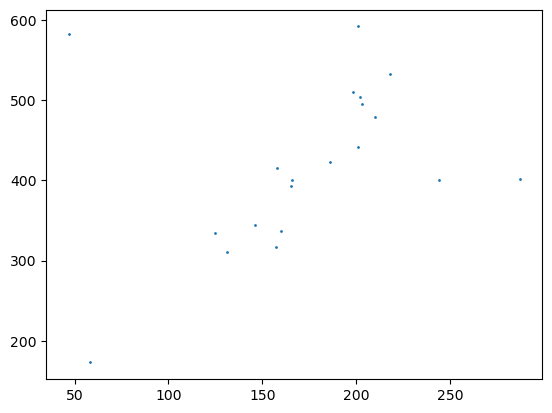

In [3]:
plt.scatter(x,y,s=1)
plt.show()

### write a function that computes the squared loss that incorporates the uncertainties on the measurements,  𝑑𝑦

In [4]:
def sq_loss_dy(a,b):
    model=a*x+b
    loss=(y-model)**2/dy**2
    return loss

### Fit a line to the full sample by evaluating this likelihood on a grid of a, b

In [5]:
aa,bb=np.arange(0.1,2,0.01),np.arange(150,250,1)

In [21]:
def likelihood(p):
    return np.sum(1/2*sq_loss_dy(p[0],p[1]))

In [7]:
ll=np.zeros((len(aa),len(bb)))
for i,onea in enumerate(aa):
    for j,oneb in enumerate(bb):
        ll[i,j]=likelihood([onea,oneb])

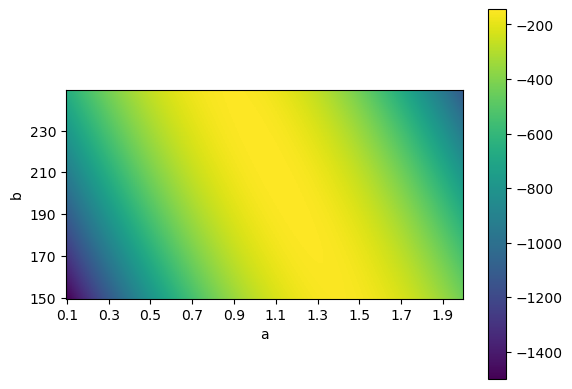

In [83]:
plt.imshow(ll.T)
plt.gca().invert_yaxis()
plt.colorbar()
xlabels=np.round(aa[::20],2)
ylabels=np.round(bb[::20],2)
plt.xticks(np.arange(len(aa))[::20],xlabels)
plt.yticks(np.arange(len(bb))[::20],ylabels)
plt.xlabel('a');plt.ylabel('b')
plt.show()

In [9]:
np.where(ll==np.max(ll))

(array([98]), array([63]))

In [10]:
ll[98,63]

-144.98480241970142

In [11]:
aa[98]

1.0799999999999996

In [12]:
bb[63]

213

In [13]:
def linear(A,B):
    return A*X+B

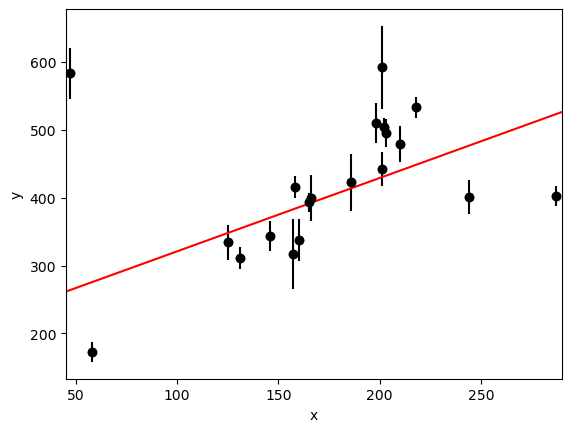

In [119]:
plt.errorbar(x,y,yerr=dy,fmt='o',color='k')
plt.scatter(x,y)
X=np.arange(40,300,10)
plt.plot(X,linear(aa[98],bb[63]),color='r')
plt.xlabel('x');plt.ylabel('y')
plt.xlim(45,290)
plt.show()

### Use sigma-clipping or an L-estimator for outlier rejection 

In [15]:
scipy.stats.sigmaclip(y,high=1.5)[0]

array([401., 402., 495., 173., 479., 504., 510., 416., 393., 442., 317.,
       311., 400., 337., 423., 334., 344.])

In [16]:
len(scipy.stats.sigmaclip(y,high=1.5)[0])

17

### and fit a line to the data with outliers rejected (10 pts)

In [17]:
yind=[]
for i,yy in enumerate(y):
    if yy in scipy.stats.sigmaclip(y,high=1.5)[0]:
        yind.append(i)

In [18]:
def linear(X,A,B):
    return A*X+B

In [52]:
def sq_loss_dy(a,b):
    model=a*x[yind]+b
    loss=(y[yind]-model)**2/dy[yind]**2
    return loss
def likelihood(p):
    return np.sum(1/2*sq_loss_dy(p[0],p[1]))

Optimization terminated successfully.
         Current function value: 87.247288
         Iterations: 47
         Function evaluations: 87


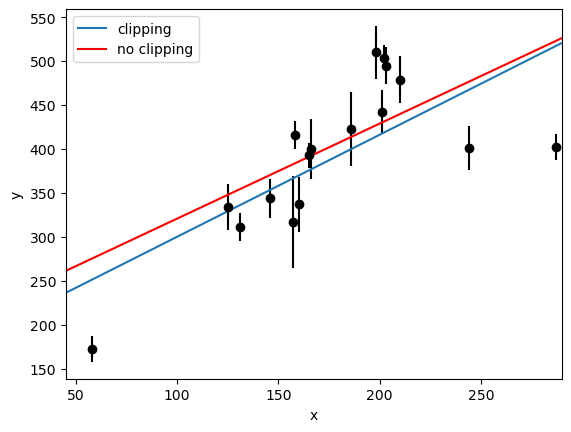

In [53]:
plt.errorbar(x[yind],y[yind],yerr=dy[yind],fmt='o',color='k')
aopt,bopt=scipy.optimize.fmin(likelihood,[1,210])
X=np.arange(40,300,10)
plt.plot(X,linear(X,aopt,bopt),label='clipping')
plt.plot(X,linear(X,aa[98],bb[63]),color='r',label='no clipping')
plt.xlabel('x');plt.ylabel('y')
plt.xlim(45,290)
plt.legend(loc=0)
plt.show()

### make a QQ plot of the residuals

In [54]:
residual=y[yind]-linear(x[yind],aopt,bopt)

In [55]:
mean=np.mean(residual)
std=np.std(residual)

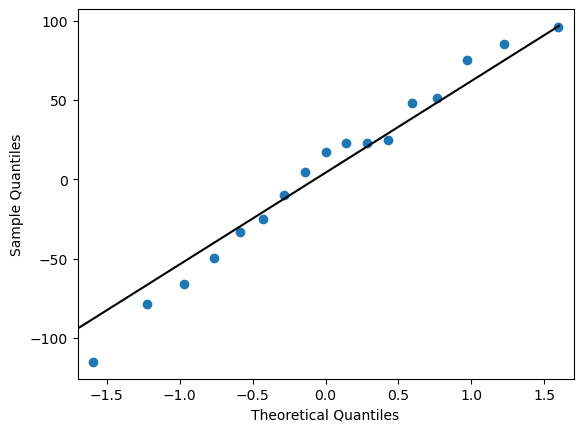

In [56]:
sm.qqplot(residual,dist=stats.norm)
plt.plot(np.arange(-1.7,1.7,0.1),linear(np.arange(-1.7,1.7,0.1),std,mean),color='k')
plt.xlim(-1.7,1.7)
plt.show()

### Define a new likelihood function that implements the Huber loss,
### also incorporating the measurement uncertainties  𝑑𝑦 (10 pts)

In [62]:
def huber(a,b):
    d=1 #assume
    model=a*x+b
    loss=np.zeros(len(y))
    for i in range(len(y)):
        if abs(y[i]-model[i]) <= d:
            loss[i]=(y[i]-model[i]/dy[i])**2
        else:
            loss[i]=d*(abs(y[i]-model[i])-d/2)/dy[i]**2
    return loss

In [61]:
def likelihood_h(p):
    return np.sum(huber(p[0],p[1])/2)

### Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search

In [63]:
scipy.optimize.fmin(likelihood_h,[1,210])

Optimization terminated successfully.
         Current function value: 1.324361
         Iterations: 96
         Function evaluations: 193


array([  1.39473567, 160.65812621])

In [64]:
haopt,hbopt=scipy.optimize.fmin(likelihood_h,[1,210])

Optimization terminated successfully.
         Current function value: 1.324361
         Iterations: 96
         Function evaluations: 193


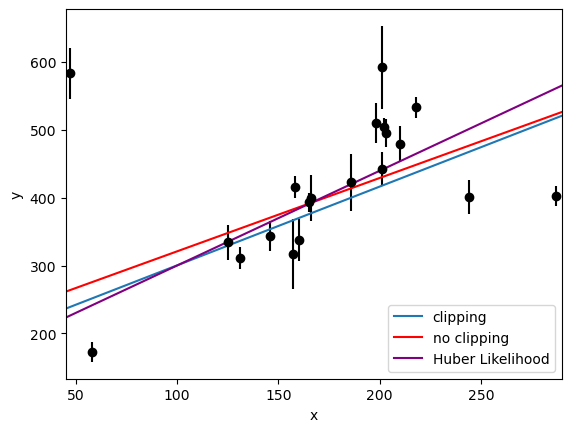

In [66]:
plt.errorbar(x,y,yerr=dy,fmt='o',color='k')
X=np.arange(40,300,10)
plt.plot(X,linear(X,aopt,bopt),label='clipping')
plt.plot(X,linear(X,aa[98],bb[63]),color='r',label='no clipping')
plt.plot(X,linear(X,haopt,hbopt),color='purple',label='Huber Likelihood')

plt.xlabel('x');plt.ylabel('y')
plt.xlim(45,290)
plt.legend(loc=0)
plt.show()

### and you know the drill by now - QQ plot of the residuals (10 pts)

In [67]:
hresidual=y-linear(x,haopt,hbopt)
mean=np.mean(hresidual)
std=np.std(hresidual)

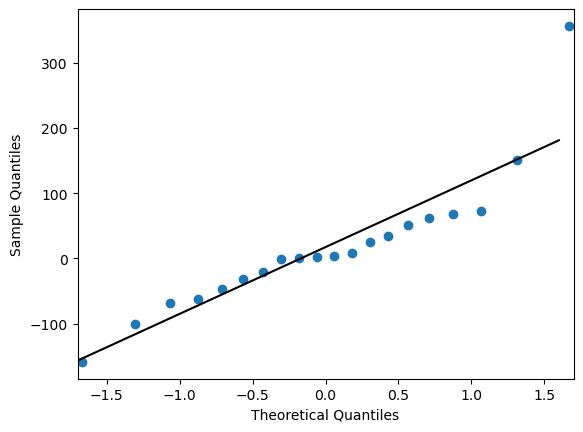

In [68]:
sm.qqplot(hresidual,dist=stats.norm)
plt.plot(np.arange(-1.7,1.7,0.1),linear(np.arange(-1.7,1.7,0.1),std,mean),color='k')
plt.xlim(-1.7,1.7)
plt.show()

## Problem 2

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing. (15 pts)

In [46]:
data = pd.read_csv('Cepheids.csv')
df = pd.DataFrame(data, columns=['name', 'RA0', 'Decl0', 'Mode', 'Cloud', 'W', 'logP1', 'VI'])

In [47]:
df

,name,RA0,Decl0,Mode,Cloud,W,logP1,VI
0,OGLE-LMC-CEP-0002,4.529733,-69.819330,F,LMC,14.52500,0.493893,0.740
1,OGLE-LMC-CEP-0005,4.592089,-69.734970,F,LMC,13.49540,0.749122,0.752
2,OGLE-LMC-CEP-0012,4.630203,-67.214420,F,LMC,14.54210,0.424912,0.598
3,OGLE-LMC-CEP-0016,4.642367,-67.646310,F,LMC,12.03300,1.021456,1.080
4,OGLE-LMC-CEP-0017,4.649119,-69.688390,F,LMC,14.34215,0.565524,0.647
...,...,...,...,...,...,...,...,...
7264,OGLE-SMC-CEP-4622,1.404808,-73.269361,1,SMC,15.94460,0.141140,0.648
7265,OGLE-SMC-CEP-4624,1.406767,-74.192639,1,SMC,15.29565,0.102449,0.577
7266,OGLE-SMC-CEP-4625,1.407181,-72.936056,1,SMC,15.33725,0.074740,0.485
7267,OGLE-SMC-CEP-4627,1.413575,-72.599167,1,SMC,14.06670,0.501477,0.686


In [48]:
lmcf=(df['Cloud']=='LMC')&(df['Mode']=='F')
lmc1=(df['Cloud']=='LMC')&(df['Mode']=='1')
smcf=(df['Cloud']=='SMC')&(df['Mode']=='F')
smc1=(df['Cloud']=='SMC')&(df['Mode']=='1')

In [49]:
df[lmc1]

,name,RA0,Decl0,Mode,Cloud,W,logP1,VI
4409,OGLE-LMC-CEP-0001,4.516036,-69.060389,1,LMC,17.16320,-0.513124,0.396
4410,OGLE-LMC-CEP-0003,4.584919,-70.424139,1,LMC,17.05340,-0.455816,0.512
4411,OGLE-LMC-CEP-0004,4.588931,-69.802139,1,LMC,14.26000,0.348228,0.560
4412,OGLE-LMC-CEP-0006,4.595044,-69.724778,1,LMC,13.66160,0.517845,0.668
4413,OGLE-LMC-CEP-0007,4.608347,-68.626583,1,LMC,15.95705,-0.149302,0.629
...,...,...,...,...,...,...,...,...
5632,OGLE-LMC-CEP-3368,5.266611,-69.513083,1,LMC,16.94960,-0.572217,0.548
5633,OGLE-LMC-CEP-3370,5.353917,-70.147611,1,LMC,16.79315,-0.569856,0.787
5634,OGLE-LMC-CEP-3371,5.526572,-70.094833,1,LMC,17.53350,-0.569003,0.570
5635,OGLE-LMC-CEP-3373,5.552631,-71.528361,1,LMC,17.51980,-0.558736,0.564


In [50]:
lmcf=df[lmcf]
lmc1=df[lmc1]
smcf=df[smcf]
smc1=df[smc1]

In [69]:
def huber(a,b):
    d=1 #assume
    model=a*x+b
    loss=np.zeros(len(y))
    for i in range(len(y)):
        if abs(y[i]-model[i]) <= d:
            loss[i]=(y[i]-model[i])**2
        else:
            loss[i]=d*(abs(y[i]-model[i])-d/2)
    return loss
def likelihood_h(p):
    return np.sum(huber(p[0],p[1])/2)

0
Optimization terminated successfully.
         Current function value: 15.108511
         Iterations: 75
         Function evaluations: 148
1
Optimization terminated successfully.
         Current function value: 11.443639
         Iterations: 79
         Function evaluations: 150
2
Optimization terminated successfully.
         Current function value: 48.028176
         Iterations: 65
         Function evaluations: 131
3
Optimization terminated successfully.
         Current function value: 31.917367
         Iterations: 42
         Function evaluations: 83


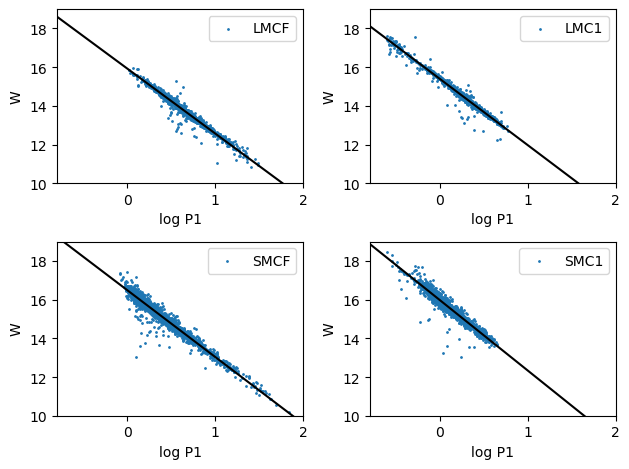

In [78]:
fig,axs=plt.subplots(2,2)
axs=axs.ravel()
for i in range(4):
    print(i)
    ax=axs[i]
    
    if i==0:
        x,y=np.array(lmcf['logP1']),np.array(lmcf['W'])
        ax.scatter(x,y,label='LMCF',s=1)
    elif i==1:
        x,y=np.array(lmc1['logP1']),np.array(lmc1['W'])
        ax.scatter(x,y,label='LMC1',s=1)
    elif i==2:
        x,y=np.array(smcf['logP1']),np.array(smcf['W'])
        ax.scatter(x,y,label='SMCF',s=1)
    elif i==3:
        x,y=np.array(smc1['logP1']),np.array(smc1['W'])
        ax.scatter(x,y,label='SMC1',s=1)
    aopt,bopt=scipy.optimize.fmin(likelihood_h,[-2,18])
    ax.legend()
    ax.set_xlabel('log P1');ax.set_ylabel('W')
    ax.set_xlim(-0.8,2);ax.set_ylim(10,19)
    
    ax.plot(np.arange(-0.8,2,0.01),linear(np.arange(-0.8,2,0.01),aopt,bopt),color='k')
plt.tight_layout()
plt.show()

### Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

Optimization terminated successfully.
         Current function value: 15.108511
         Iterations: 75
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 11.443639
         Iterations: 79
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 48.028176
         Iterations: 65
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 31.917367
         Iterations: 42
         Function evaluations: 83


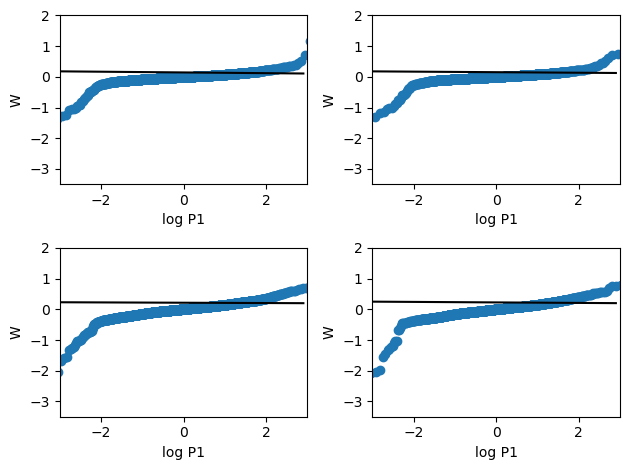

In [83]:
fig,axs=plt.subplots(2,2)
axs=axs.ravel()
for i in range(4):
    ax=axs[i]
    
    if i==0:
        x,y=np.array(lmcf['logP1']),np.array(lmcf['W'])
    elif i==1:
        x,y=np.array(lmc1['logP1']),np.array(lmc1['W'])
    elif i==2:
        x,y=np.array(smcf['logP1']),np.array(smcf['W'])
    elif i==3:
        x,y=np.array(smc1['logP1']),np.array(smc1['W'])
        
    aopt,bopt=scipy.optimize.fmin(likelihood_h,[-2,18])
    hresidual=y-linear(x,aopt,bopt)
    mean=np.mean(hresidual)
    std=np.std(hresidual)
    
    sm.qqplot(hresidual,dist=stats.norm,ax=ax)
    ax.plot(np.arange(-3,3,0.1),linear(np.arange(-3,3,0.1),mean,std),color='k')
    
    #ax.legend()
    ax.set_xlabel('log P1');ax.set_ylabel('W')
    ax.set_xlim(-3,3);ax.set_ylim(-3.5,2)
    
plt.tight_layout()
plt.show()

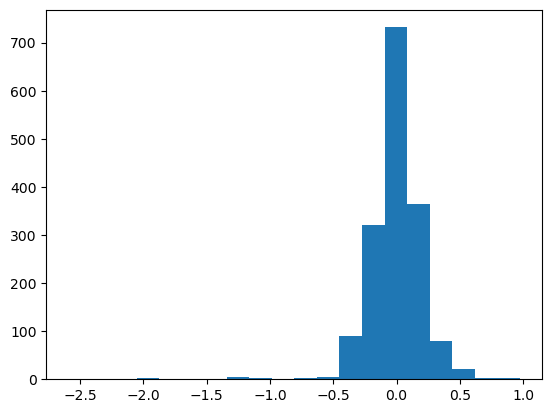

In [86]:
plt.hist(hresidual,bins=20);plt.show()

In [67]:
They are not normal distribution. 
It can be seen visually, with a high concentration in the middle.
This means the cepheids have little residual,
which means they can be used as a good distance ladder.

### Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

Optimization terminated successfully.
         Current function value: 15.108511
         Iterations: 75
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 11.443639
         Iterations: 79
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 48.028176
         Iterations: 65
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 31.917367
         Iterations: 42
         Function evaluations: 83


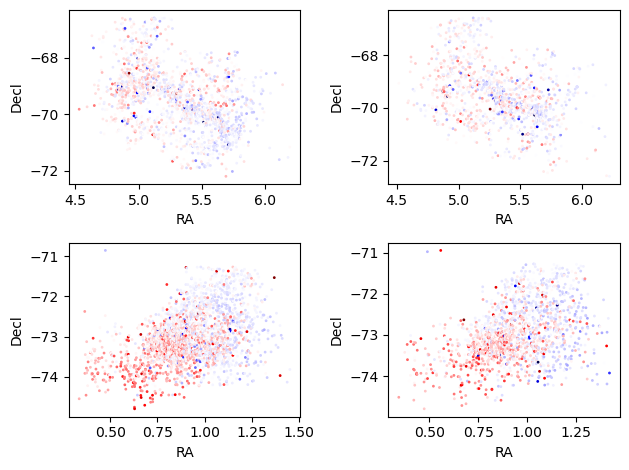

In [105]:
import matplotlib.colors as colors

fig,axs=plt.subplots(2,2)
axs=axs.ravel()
for i in range(4):
    ax=axs[i]
    
    if i==0:
        x,y=np.array(lmcf['logP1']),np.array(lmcf['W'])
        ra,dec=np.array(lmcf['RA0']),np.array(lmcf['Decl0'])
    elif i==1:
        x,y=np.array(lmc1['logP1']),np.array(lmc1['W'])
        ra,dec=np.array(lmc1['RA0']),np.array(lmc1['Decl0'])
    elif i==2:
        x,y=np.array(smcf['logP1']),np.array(smcf['W'])
        ra,dec=np.array(smcf['RA0']),np.array(smcf['Decl0'])
    elif i==3:
        x,y=np.array(smc1['logP1']),np.array(smc1['W'])
        ra,dec=np.array(smc1['RA0']),np.array(smc1['Decl0'])
        
    aopt,bopt=scipy.optimize.fmin(likelihood_h,[-2,18])
    hresidual=y-linear(x,aopt,bopt)
    
    #Set colormap norm
    divnorm = colors.TwoSlopeNorm(vmax=np.max(hresidual),vmin=np.min(hresidual), vcenter=0)
    
    ax.scatter(ra,dec,c=hresidual,cmap='seismic',alpha=1,s=1,norm=divnorm)
    
    #ax.legend()
    ax.set_xlabel('RA');ax.set_ylabel('Decl')
    #ax.set_xlim(-3,3);ax.set_ylim(-3.5,2)
    
plt.tight_layout()
plt.show()

### Finally, plot the residuals against the fitted W values, 

Optimization terminated successfully.
         Current function value: 15.108511
         Iterations: 75
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 11.443639
         Iterations: 79
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 48.028176
         Iterations: 65
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: 31.917367
         Iterations: 42
         Function evaluations: 83


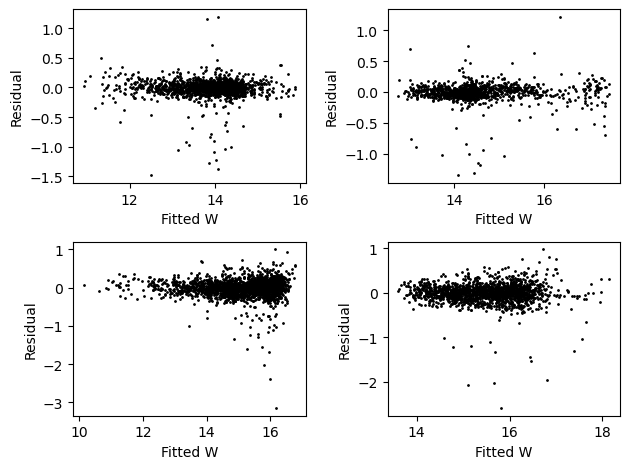

In [112]:
import matplotlib.colors as colors

fig,axs=plt.subplots(2,2)
axs=axs.ravel()
for i in range(4):
    ax=axs[i]
    
    if i==0:
        x,y=np.array(lmcf['logP1']),np.array(lmcf['W'])
        ra,dec=np.array(lmcf['RA0']),np.array(lmcf['Decl0'])
    elif i==1:
        x,y=np.array(lmc1['logP1']),np.array(lmc1['W'])
        ra,dec=np.array(lmc1['RA0']),np.array(lmc1['Decl0'])
    elif i==2:
        x,y=np.array(smcf['logP1']),np.array(smcf['W'])
        ra,dec=np.array(smcf['RA0']),np.array(smcf['Decl0'])
    elif i==3:
        x,y=np.array(smc1['logP1']),np.array(smc1['W'])
        ra,dec=np.array(smc1['RA0']),np.array(smc1['Decl0'])
        
    aopt,bopt=scipy.optimize.fmin(likelihood_h,[-2,18])
    hresidual=y-linear(x,aopt,bopt)
    
    ax.scatter(linear(x,aopt,bopt),hresidual,color='k',s=1)
    
    ax.set_xlabel('Fitted W');ax.set_ylabel('Residual')
plt.tight_layout()
plt.show()

In [ ]:
The residual is around zero regardless of the Wesenheit index.
This is because it is insensitive to extinction?

### also plot log(P1) vs V-I. Comment on what you are seeing. (15 pts)

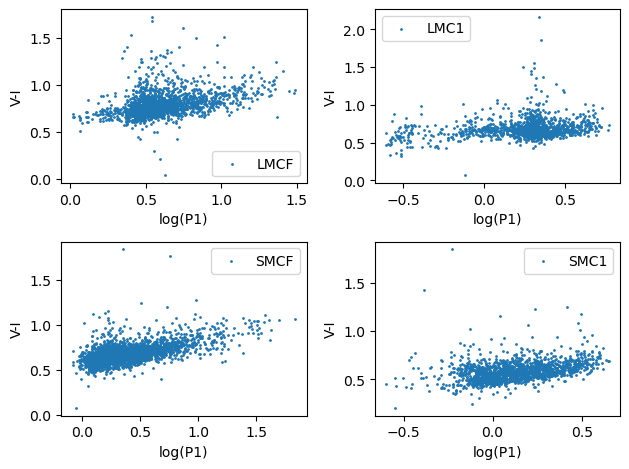

In [109]:
fig,axs=plt.subplots(2,2)
axs=axs.ravel()
for i in range(4):
    ax=axs[i]
    
    if i==0:
        x,y=np.array(lmcf['logP1']),np.array(lmcf['VI'])
        ax.scatter(x,y,label='LMCF',s=1)
    elif i==1:
        x,y=np.array(lmc1['logP1']),np.array(lmc1['VI'])
        ax.scatter(x,y,label='LMC1',s=1)
    elif i==2:
        x,y=np.array(smcf['logP1']),np.array(smcf['VI'])
        ax.scatter(x,y,label='SMCF',s=1)
    elif i==3:
        x,y=np.array(smc1['logP1']),np.array(smc1['VI'])
        ax.scatter(x,y,label='SMC1',s=1)
    ax.legend()
    ax.set_xlabel('log(P1)');ax.set_ylabel('V-I')
    
plt.tight_layout()
plt.show()

In [ ]:
There is a positive relation between period and color of the cepheids.